In [1]:
# Necessary Imports
%matplotlib inline
import numpy as np
import pandas as pd
from dataset import Dataset
from sklearn import tree
import sklearn.metrics
import matplotlib.pyplot as plt

In [2]:
TRAIN_DATA_PATH = "data/ann-train.data"
TEST_DATA_PATH = "data/ann-test.data"
COST_DATA_PATH = "data/ann-thyroid.cost"

dataset = Dataset(TRAIN_DATA_PATH, TEST_DATA_PATH, COST_DATA_PATH)
train_sample_count = len(dataset.train_data.index)
test_sample_count = len(dataset.test_data.index)
print("Dataset Imported: There are " + str(train_sample_count) + " training samples, and " + str(test_sample_count) + " test samples.")

Dataset Imported: There are 3772 training samples, and 3428 test samples.


In [3]:
def evaluate_matrix(matrix):
    assert matrix.shape[0] == matrix.shape[1]
    no_of_classes = matrix.shape[0]
    overall_acc = sum([matrix[i, i] for i in range(matrix.shape[0])]) / np.sum(matrix)
    accuracies = []
    for class_no in range(matrix.shape[0]):
        if np.sum(matrix[class_no, :]) == 0:
            acc = 0
        else:
            acc = matrix[class_no, class_no] / np.sum(matrix[class_no, :])
        accuracies.append(acc)
    return overall_acc, accuracies

In [4]:
import seaborn as sn
def plot_matrix(confusion_matrix):
    matrix_df = pd.DataFrame(confusion_matrix, index=["1", "2", "3"], columns=["1", "2", "3"])
    matrix_df.index.name = "True Label"
    matrix_df.columns.name = "Predicted Label"
    plt.figure(figsize = (8,5))
    sn.set(font_scale=1.4)
    sn.heatmap(matrix_df,annot=True, fmt="d", linewidths=.5, annot_kws={"size": 18}, cmap="Blues")

In [5]:
def get_best_classifier(dataset):
    train_data = dataset.train_data.copy()
    labels = train_data["y"].to_numpy()
    train_samples = train_data.drop(columns=["y"]).to_numpy()
    test_data = dataset.test_data.copy()
    test_labels = test_data["y"].to_numpy()
    test_samples = test_data.drop(columns=["y"]).to_numpy()
    metrics = ["gini", "entropy"]
    split_type = ["best", "random"]
    tree_length_limit = range(1,10)
    impurity_limit = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7]
    classes, counts = np.unique(test_labels, return_counts=True)
    weights = np.array([counts[1] * counts[2], counts[0] * counts[2], counts[1] * counts[0]])
    weights = weights / np.sum(weights)
    best_acc = 0.0
    best_metric = None
    best_split = None
    best_length = None
    best_limit = None
    for metric in metrics:
        for split in split_type:
            for tree_length in tree_length_limit:
                for limit in impurity_limit:
                    classifier = tree.DecisionTreeClassifier(criterion=metric, splitter=split, max_depth=tree_length, min_impurity_decrease=limit)
                    classifier.fit(train_samples, labels)
                    y_pred = classifier.predict(test_samples)
                    confusion_matrix = sklearn.metrics.confusion_matrix(test_labels, y_pred)
                    acc_values = np.array([confusion_matrix[0,0] / np.sum(confusion_matrix[0,:]), confusion_matrix[1,1] / np.sum(confusion_matrix[1,:]), confusion_matrix[2,2] / np.sum(confusion_matrix[2,:])])
                    acc_score = np.sum(weights * acc_values)
                    if acc_score > best_acc:
                        best_acc = acc_score
                        best_metric = metric
                        best_split = split
                        best_length = tree_length
                        best_limit = limit
    return best_acc, best_metric, best_split, best_length, best_limit

## Finding optimal decision tree
In order to find the optimal hyperparameters for the decision tree, the grid search is performed with the function above. With the hyperparameters found the acuracy values are reported.
#### Reporting results for test set
Here in the following output cell the accuracy values and the confusion matrix for **test set** is reported.

(0.9998690771228046, 'entropy', 'best', 4, 0.01)
Overall Accuracy: 0.9924154025670945
Class 1 Accuracy: 1.0
Class 2 Accuracy: 1.0
Class 3 Accuracy: 0.9918187539332913


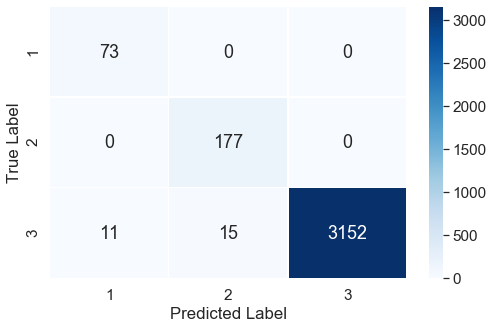

In [6]:
best_metrics = get_best_classifier(dataset)
print(best_metrics)
best_classifier = tree.DecisionTreeClassifier(criterion=best_metrics[1], splitter=best_metrics[2], max_depth=best_metrics[3], min_impurity_decrease=best_metrics[4])
train_samples = dataset.train_data.to_numpy()[:,:-1]
train_labels = dataset.train_data.to_numpy()[:,-1]
best_classifier.fit(train_samples, train_labels)
test_samples = dataset.test_data.to_numpy()[:,:-1]
test_labels = dataset.test_data.to_numpy()[:,-1]
y_pred = best_classifier.predict(test_samples)
confusion_matrix = sklearn.metrics.confusion_matrix(test_labels, y_pred)
acc_values = evaluate_matrix(confusion_matrix)
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 2 Accuracy: {}".format(acc_values[1][1]))
print("Class 3 Accuracy: {}".format(acc_values[1][2]))
plot_matrix(confusion_matrix)

#### Reporting results for the training set
The same approach is also followed for the training set. The results for the training set with the optimal hyperparameters are given as follows:

Overall Accuracy: 0.9960233297985154
Class 1 Accuracy: 1.0
Class 2 Accuracy: 1.0
Class 3 Accuracy: 0.9956995412844036


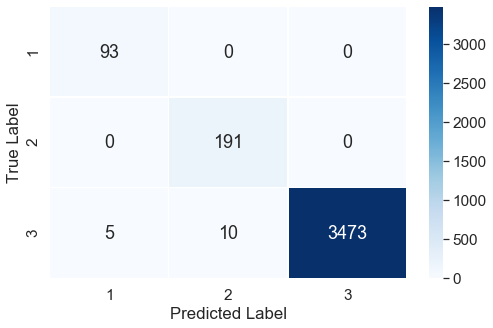

In [7]:
y_pred = best_classifier.predict(train_samples)
matrix = sklearn.metrics.confusion_matrix(train_labels, y_pred)
acc_values = evaluate_matrix(matrix)
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 2 Accuracy: {}".format(acc_values[1][1]))
print("Class 3 Accuracy: {}".format(acc_values[1][2]))
plot_matrix(matrix)

The optimal subtree with the determined hyperparameters are visualized in the following way by using the scikit-learn library:

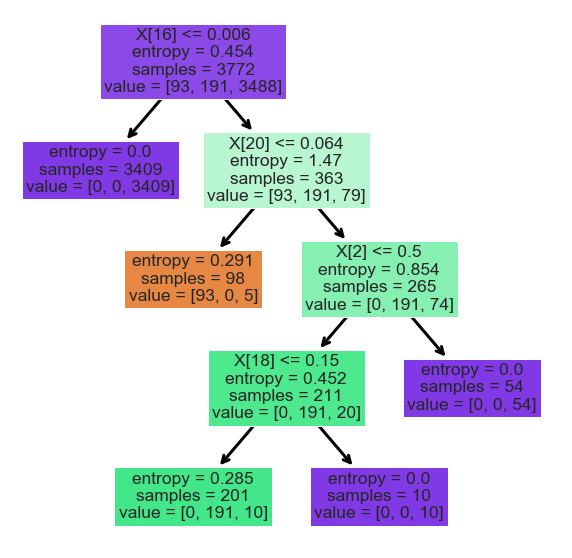

In [8]:
plt.figure(figsize=(10,10))
out = tree.plot_tree(best_classifier, filled=True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)

### Effect of Pruning
To observe the effect of pruning, a classifier with no pruning is constructed. The metrics for the **training set** with the fully grown tree is provided below:

Overall Accuracy: 1.0
Class 1 Accuracy: 1.0
Class 2 Accuracy: 1.0
Class 3 Accuracy: 1.0


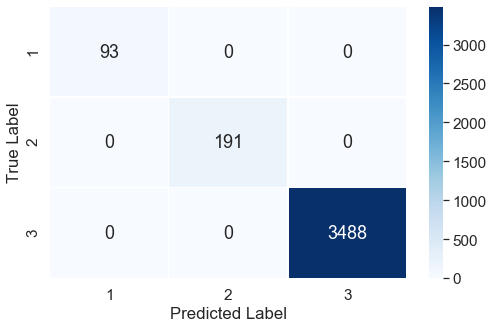

In [18]:
classifier = tree.DecisionTreeClassifier(criterion="entropy")
classifier.fit(train_samples, train_labels)
y_pred_train = classifier.predict(train_samples)
matrix_train = sklearn.metrics.confusion_matrix(train_labels, y_pred_train)
acc_values = evaluate_matrix(matrix_train)
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 2 Accuracy: {}".format(acc_values[1][1]))
print("Class 3 Accuracy: {}".format(acc_values[1][2]))
plot_matrix(matrix_train)

As the continuation of the analysis, the prediction metrics of the fully grown tree for the **test set** is provided as follows. As expected it predicts each training sample true.

Overall Accuracy: 0.9932905484247374
Class 1 Accuracy: 0.9452054794520548
Class 2 Accuracy: 1.0
Class 3 Accuracy: 0.9940213971050975


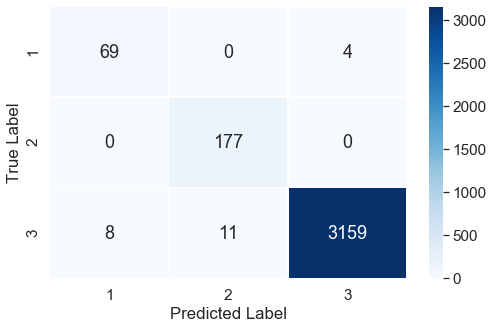

In [10]:
y_pred_test = classifier.predict(test_samples)
matrix_test = sklearn.metrics.confusion_matrix(test_labels, y_pred_test)
acc_values = evaluate_matrix(matrix_test)
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 2 Accuracy: {}".format(acc_values[1][1]))
print("Class 3 Accuracy: {}".format(acc_values[1][2]))
plot_matrix(matrix_test)

To show the fully grown tree, the classifier where no pruning applied is visualized. The visualization is given in the following output cell:

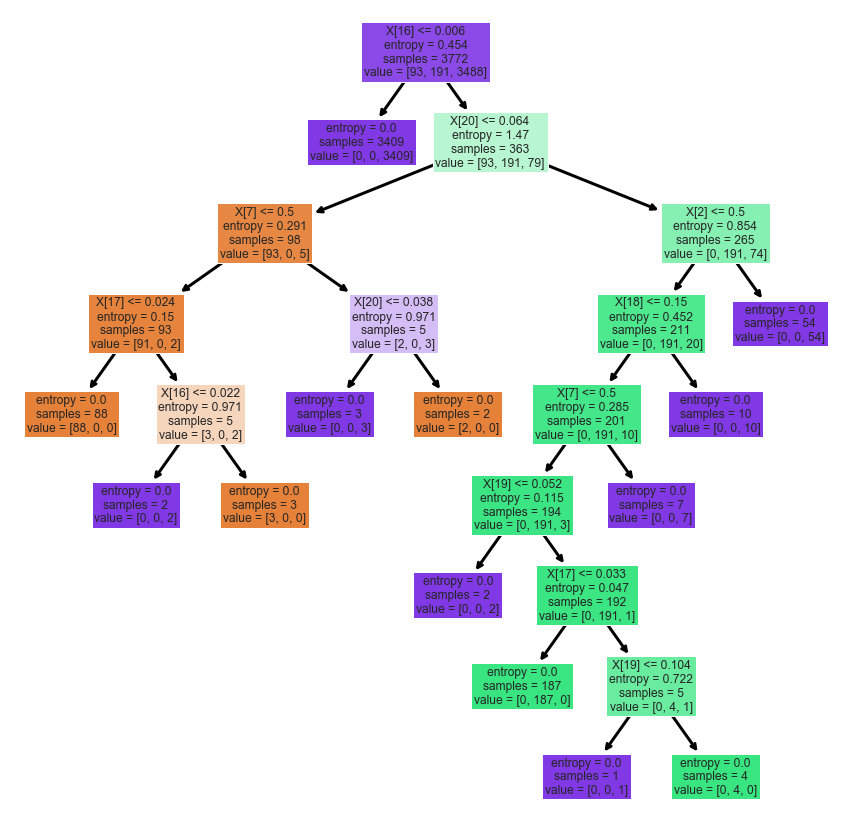

In [19]:
plt.figure(figsize=(15,15))
out = tree.plot_tree(classifier, filled=True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)

In [11]:
def normalize_features(train_samples, test_samples):
    train = train_samples.copy()
    test = test_samples.copy()
    mean_vector = np.mean(train, axis=0)
    std_vector = np.std(train, axis=0)
    for sample_idx in range(train.shape[0]):
        train[sample_idx,:] = (train[sample_idx,:] - mean_vector) / (std_vector)
    for sample_idx in range(test.shape[0]):
        test[sample_idx,:] = (test[sample_idx,:] - mean_vector) / (std_vector)
    return train, test

To see the effect of normalization the following normalization is applied:<br>
$\LARGE{X = \frac{X - \mu_{train}}{\sigma_{train}}}$<br>
The results for the **test samples** and **training samples** are given in the respective order is given below:

Test Set
Overall Accuracy: 0.9924154025670945
Class 1 Accuracy: 1.0
Class 2 Accuracy: 1.0
Class 3 Accuracy: 0.9918187539332913
Training Set
Overall Accuracy: 0.9960233297985154
Class 1 Accuracy: 1.0
Class 2 Accuracy: 1.0
Class 3 Accuracy: 0.9956995412844036


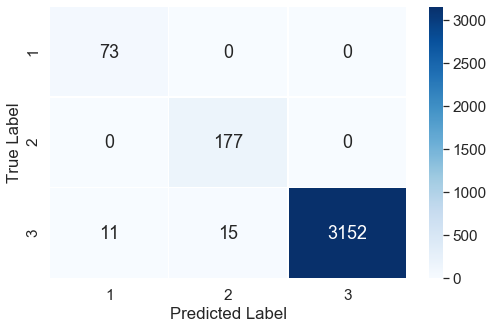

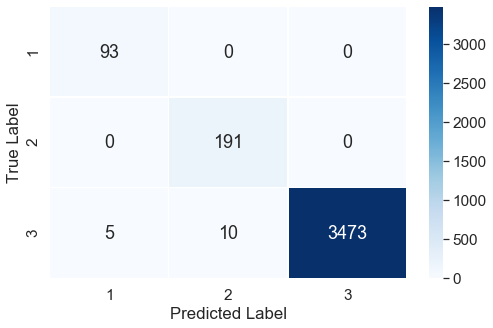

In [12]:
normalized_train_samples, normalized_test_samples = normalize_features(train_samples, test_samples)
best_classifier.fit(normalized_train_samples, train_labels)
normalized_y_pred = best_classifier.predict(normalized_test_samples)
matrix_normalized = sklearn.metrics.confusion_matrix(test_labels, normalized_y_pred)
normalized_y_pred_train = best_classifier.predict(normalized_train_samples)
matrix_normalized_train = sklearn.metrics.confusion_matrix(train_labels, normalized_y_pred_train)
acc_values = evaluate_matrix(matrix_normalized)
print("Test Set")
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 2 Accuracy: {}".format(acc_values[1][1]))
print("Class 3 Accuracy: {}".format(acc_values[1][2]))
plot_matrix(matrix_normalized)
acc_values = evaluate_matrix(matrix_normalized_train)
print("Training Set")
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 2 Accuracy: {}".format(acc_values[1][1]))
print("Class 3 Accuracy: {}".format(acc_values[1][2]))
plot_matrix(matrix_normalized_train)

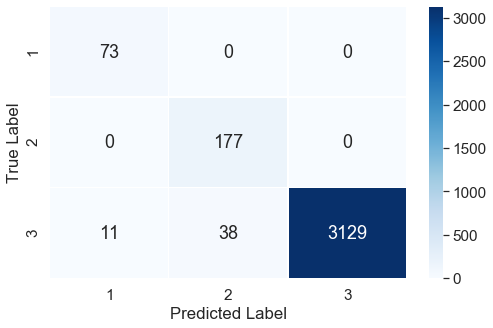

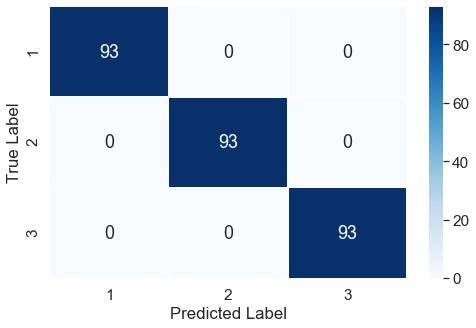

In [13]:
def undersample_data(train_samples):
    classes, frequencies = np.unique(train_samples[:,-1], return_counts=True)
    train_data = np.copy(train_samples)
    np.random.shuffle(train_data)
    min_frequency = np.min(frequencies)
    sample_counts = [0, 0, 0]
    samples = []
    for data_idx in range(train_data.shape[0]):
        label = int(train_data[data_idx,-1])
        if sample_counts[label - 1] < min_frequency:
            samples.append(train_data[data_idx,:])
            sample_counts[label - 1] += 1
    return np.array(samples)
sampled_data = undersample_data(dataset.train_data.to_numpy())
best_classifier.fit(sampled_data[:,:-1], sampled_data[:,-1])
sampled_y_pred = best_classifier.predict(test_samples)
sampled_y_pred_train = best_classifier.predict(sampled_data[:,:-1])
sampled_matrix = sklearn.metrics.confusion_matrix(test_labels, sampled_y_pred)
sampled = best_classifier.predict(sampled_data[:,:-1])
sampled_matrix_train = sklearn.metrics.confusion_matrix(sampled_data[:,-1], sampled_y_pred_train)
plot_matrix(sampled_matrix)
plot_matrix(sampled_matrix_train)

## Effect of Undersampling
In order to observe the effect of class imbalance, undersampling method is applied. The respective results for **test set** and **training set** is provided:

In [14]:
acc_values = evaluate_matrix(sampled_matrix)
print("Test Set")
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 2 Accuracy: {}".format(acc_values[1][1]))
print("Class 3 Accuracy: {}".format(acc_values[1][2]))
acc_values = evaluate_matrix(sampled_matrix_train)
print("Test Set")
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 2 Accuracy: {}".format(acc_values[1][1]))
print("Class 3 Accuracy: {}".format(acc_values[1][2]))

Test Set
Overall Accuracy: 0.985705950991832
Class 1 Accuracy: 1.0
Class 2 Accuracy: 1.0
Class 3 Accuracy: 0.9845814977973568
Test Set
Overall Accuracy: 1.0
Class 1 Accuracy: 1.0
Class 2 Accuracy: 1.0
Class 3 Accuracy: 1.0
